In [170]:
# Importación de bibliotecas estándar
import numpy as np
import pandas as pd

# Importación de bibliotecas para visualización
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.patches as mpatches

# Importando itertools para generar combinaciones de columnas
import itertools 

# Importando la función seasonal_decompose para la descomposición de series temporales
from statsmodels.tsa.seasonal import seasonal_decompose

# Importación de herramientas para modelos de machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import learning_curve
from sklearn.metrics import roc_auc_score, log_loss
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score, cross_validate
from sklearn.metrics import make_scorer

# Importación de módulo personalizado
import payments_manager as pm

cr_cp = pm.df('cr_cp')
fe_cp = pm.df('fe_cp')
df_jo = pm.df('df_jo')
#df_jo = pm.sort("df_jo", ["id_cr"]).reset_index()
#df_jo = df_jo.drop(columns=['index'])
#df_jo = df_jo.drop(columns=['Mes_created_at'])
#df_jo_cp = df_jo.copy()
df_jo = pm.sort("df_jo", ["id_cr"]).reset_index()
df_jo = df_jo.drop(columns=['index'])
#df_jo.info()


In [171]:
# Datos de partida
pd.options.display.max_columns = None
pm.format_to_dates(df_jo, time_format='d') # 'min','s'
df = pm.df('df_hyper')
display(df)

,user_id,created_at_slot,created_at_dow,amount,n_fees,n_backs,n_recovery,n_inc_back,n_inc_fees,transfer_type,charge_moment,n_cr_fe_w,inflation,GBP_EUR,BTC_GBP,unemploy_rate,needs_m_check_recov
0,47,13,1,1.0,0,0,0,1,0,regular,NaN,0,1.3,1.16935,6347.577148,3.9,1
1,99001309,14,0,100.0,0,1,0,0,0,regular,NaN,1,1.3,1.18803,5630.115723,4.0,0
2,804,19,1,100.0,0,0,0,1,0,regular,NaN,0,1.3,1.18800,5543.707520,4.0,1
3,812,19,1,100.0,0,0,1,1,0,regular,NaN,0,1.3,1.18800,5543.707520,4.0,1
4,191,19,1,100.0,0,0,0,1,0,regular,NaN,0,1.3,1.18800,5543.707520,4.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32087,55916,23,6,50.0,2,2,0,1,0,instant,after,1,0.7,0.00000,10627.522461,5.3,0
32088,39339,23,6,100.0,3,3,0,0,0,instant,after,1,0.7,0.00000,10627.522461,5.3,0
32089,24505,23,6,50.0,2,2,3,4,4,instant,NaN,0,0.7,0.00000,10627.522461,5.3,1
32090,100781,23,6,60.0,1,1,0,0,0,instant,after,1,0.7,0.00000,10627.522461,5.3,0


In [172]:
#VERIFICACION DE BALANCEO DE CLASES

# value_counts_all = df_jo['needs_m_check_recov'].value_counts()
# total_all = value_counts_all[0] + value_counts_all[1]
# needs_manual_all = (value_counts_all[1] / total_all) * 100
# print(f'Porcentaje de operaciones con needs_m_check del total de clientes: {needs_manual_all:.2f} %')

# Separar características y variable objetivo
X = df.drop(columns=['needs_m_check_recov'])  # Todas las columnas excepto la target
y = df['needs_m_check_recov']  # Columna objetivo

# Instanciar RandomUnderSampler
rus = RandomUnderSampler(random_state=42)

# Aplicar el muestreo
X_resampled, y_resampled = rus.fit_resample(X, y)

# Reconstruir un nuevo dataframe balanceado
df_balanced = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), 
                          pd.DataFrame(y_resampled, columns=['needs_m_check_recov'])], axis=1)

# Verificar el balanceo
#print(f"{df_resampled.value_counts()}")
print(f"tamaño original: {len(df_jo)} tamaño balanceado: {len(df_balanced)}")
print(df_balanced['needs_m_check_recov'].value_counts())
df_balanced       

tamaño original: 32092 tamaño balanceado: 30608
needs_m_check_recov
0    15304
1    15304
Name: count, dtype: int64


/home/albagd/ProyectoPastaLoca2/myenv/lib/python3.10/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/home/albagd/ProyectoPastaLoca2/myenv/lib/python3.10/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


,user_id,created_at_slot,created_at_dow,amount,n_fees,n_backs,n_recovery,n_inc_back,n_inc_fees,transfer_type,charge_moment,n_cr_fe_w,inflation,GBP_EUR,BTC_GBP,unemploy_rate,needs_m_check_recov
1,99001309,14,0,100.0,0,1,0,0,0,regular,NaN,1,1.3,1.18803,5630.115723,4.0,0
7,735,19,1,100.0,0,1,0,0,0,regular,NaN,1,1.3,1.18800,5543.707520,4.0,0
9,140,19,1,100.0,0,1,0,0,0,regular,NaN,1,1.3,1.18800,5543.707520,4.0,0
10,1145,19,1,100.0,0,1,0,0,0,regular,NaN,1,1.3,1.18800,5543.707520,4.0,0
13,984,19,1,30.0,0,1,0,0,0,regular,NaN,1,1.3,1.18800,5543.707520,4.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13553,33222,21,2,100.0,0,0,0,6,0,instant,NaN,0,0.2,1.11189,8880.038086,5.0,1
14996,2656,13,3,100.0,1,4,2,1,2,regular,NaN,0,0.2,1.10670,8984.978516,5.0,1
29830,99024734,16,0,100.0,1,1,0,0,1,instant,before,1,0.7,1.10162,10046.040039,5.2,1
31153,99016938,9,3,50.0,0,0,0,1,0,instant,NaN,0,0.7,1.10554,10391.864258,5.2,1


In [173]:
X_log_L=df_balanced
y_log_L=y_resampled

In [174]:
X_log_L.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30608 entries, 1 to 16549
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              30608 non-null  int64  
 1   created_at_slot      30608 non-null  int32  
 2   created_at_dow       30608 non-null  int32  
 3   amount               30608 non-null  float64
 4   n_fees               30608 non-null  int64  
 5   n_backs              30608 non-null  int64  
 6   n_recovery           30608 non-null  int64  
 7   n_inc_back           30608 non-null  int64  
 8   n_inc_fees           30608 non-null  int64  
 9   transfer_type        30608 non-null  object 
 10  charge_moment        20217 non-null  object 
 11  n_cr_fe_w            30608 non-null  int64  
 12  inflation            30608 non-null  float64
 13  GBP_EUR              30608 non-null  float64
 14  BTC_GBP              30608 non-null  float64
 15  unemploy_rate        30608 non-null  obje

In [175]:
# Convertir las columnas de tipo timedelta64
#for col in X_log_L.select_dtypes(include=['timedelta64']).columns:
#    X_log_L[col] = X_log_L[col].apply(lambda x: x / pd.to_timedelta(1, unit='d') if pd.notnull(x) else None)

In [176]:
# Convertir las columnas de tipo datetime64
#for col in X_log_L.select_dtypes(include=['datetime64']).columns:
#    X_log_L[col] = X_log_L[col].apply(lambda x: x.timestamp() if pd.notnull(x) else None)

In [177]:
# One Hot econding para pasar a numéricas todas las categóricas
X_log_L = pd.get_dummies(X_log_L, columns=['transfer_type'], drop_first=True, dtype=int)

In [178]:
X_log_L = pd.get_dummies(X_log_L, columns= ['charge_moment'], drop_first=True, dtype=int)

In [179]:
# Rellenar NaN con 0
X_log_L = X_log_L.fillna(0)

In [180]:
X_log_L

,user_id,created_at_slot,created_at_dow,amount,n_fees,n_backs,n_recovery,n_inc_back,n_inc_fees,n_cr_fe_w,inflation,GBP_EUR,BTC_GBP,unemploy_rate,needs_m_check_recov,transfer_type_regular,charge_moment_before
1,99001309,14,0,100.0,0,1,0,0,0,1,1.3,1.18803,5630.115723,4.0,0,1,0
7,735,19,1,100.0,0,1,0,0,0,1,1.3,1.18800,5543.707520,4.0,0,1,0
9,140,19,1,100.0,0,1,0,0,0,1,1.3,1.18800,5543.707520,4.0,0,1,0
10,1145,19,1,100.0,0,1,0,0,0,1,1.3,1.18800,5543.707520,4.0,0,1,0
13,984,19,1,30.0,0,1,0,0,0,1,1.3,1.18800,5543.707520,4.0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13553,33222,21,2,100.0,0,0,0,6,0,0,0.2,1.11189,8880.038086,5.0,1,0,0
14996,2656,13,3,100.0,1,4,2,1,2,0,0.2,1.10670,8984.978516,5.0,1,1,0
29830,99024734,16,0,100.0,1,1,0,0,1,1,0.7,1.10162,10046.040039,5.2,1,0,1
31153,99016938,9,3,50.0,0,0,0,1,0,0,0.7,1.10554,10391.864258,5.2,1,0,0


In [181]:
X_log_L.isnull()

,user_id,created_at_slot,created_at_dow,amount,n_fees,n_backs,n_recovery,n_inc_back,n_inc_fees,n_cr_fe_w,inflation,GBP_EUR,BTC_GBP,unemploy_rate,needs_m_check_recov,transfer_type_regular,charge_moment_before
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
7,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
9,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
10,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
13,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13553,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
14996,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
29830,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
31153,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


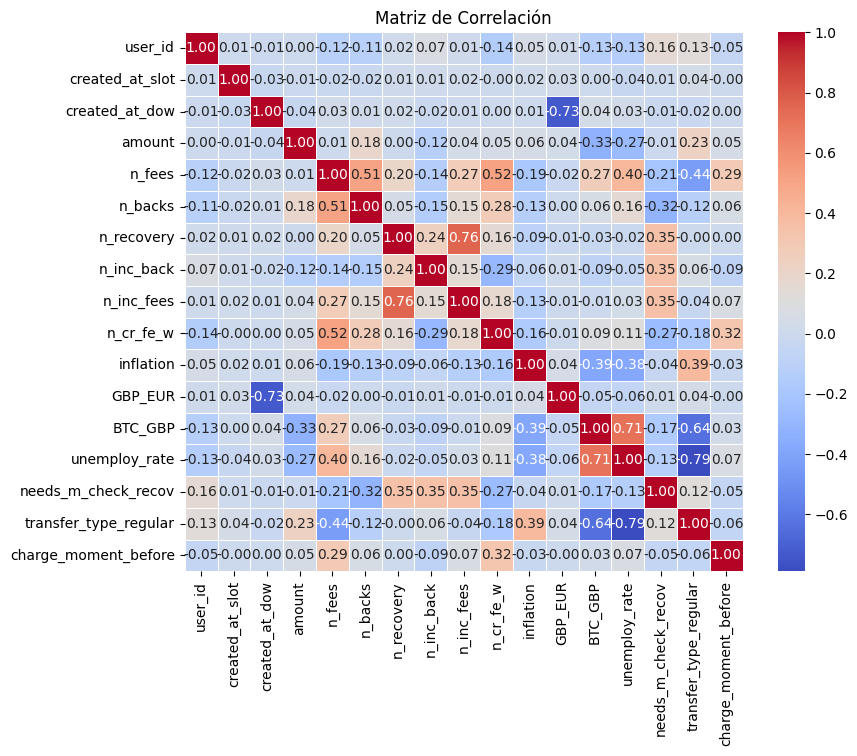

In [182]:
# Calcular la matriz de correlación
m_corr = X_log_L.corr()

# Visualizar la matriz de correlación
plt.figure(figsize=(9, 7))
sns.heatmap(m_corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Matriz de Correlación')
plt.show()

In [183]:
# Visualización datos antes del escalador
display(X_log_L.head(10))

# Sacamos la variable objetivo que no se va a escalar
y = X_log_L['needs_m_check_recov'].copy()  #Segun moderated_at
X_log_L = X_log_L.drop(columns=['needs_m_check_recov'])

# Crear el escalador en este caso STANDARDSCALER
scaler = StandardScaler()

# Estandarizar todas las columnas
normalizado = scaler.fit_transform(X_log_L)

# Convertir de nuevo a DataFrame, preservando nombres de columnas e índices
X = pd.DataFrame(normalizado, columns=X_log_L.columns, index=df_balanced.index)

# Visualización datos después del escalador
display(X.head(10))

,user_id,created_at_slot,created_at_dow,amount,n_fees,n_backs,n_recovery,n_inc_back,n_inc_fees,n_cr_fe_w,inflation,GBP_EUR,BTC_GBP,unemploy_rate,needs_m_check_recov,transfer_type_regular,charge_moment_before
1,99001309,14,0,100.0,0,1,0,0,0,1,1.3,1.18803,5630.115723,4.0,0,1,0
7,735,19,1,100.0,0,1,0,0,0,1,1.3,1.18800,5543.707520,4.0,0,1,0
9,140,19,1,100.0,0,1,0,0,0,1,1.3,1.18800,5543.707520,4.0,0,1,0
10,1145,19,1,100.0,0,1,0,0,0,1,1.3,1.18800,5543.707520,4.0,0,1,0
13,984,19,1,30.0,0,1,0,0,0,1,1.3,1.18800,5543.707520,4.0,0,1,0
16,895,20,1,100.0,0,1,0,0,0,1,1.3,1.18800,5543.707520,4.0,0,1,0
17,227,20,1,100.0,0,1,0,0,0,1,1.3,1.18800,5543.707520,4.0,0,1,0
19,99004217,22,1,80.0,0,1,0,0,0,1,1.3,1.18800,5543.707520,4.0,0,1,0
20,1257,1,2,100.0,0,1,0,0,0,1,1.3,1.18365,5468.038086,4.0,0,1,0
21,205,2,2,100.0,0,1,0,0,0,1,1.3,1.18365,5468.038086,4.0,0,1,0


,user_id,created_at_slot,created_at_dow,amount,n_fees,n_backs,n_recovery,n_inc_back,n_inc_fees,n_cr_fe_w,inflation,GBP_EUR,BTC_GBP,unemploy_rate,transfer_type_regular,charge_moment_before
1,3.449040,0.255867,-1.506685,0.634641,-0.877507,-0.343263,-0.409684,-0.51782,-0.492353,-0.023796,2.327459,0.684299,-2.651036,-2.645363,1.251596,-0.396708
7,-0.291090,1.205818,-0.959521,0.634641,-0.877507,-0.343263,-0.409684,-0.51782,-0.492353,-0.023796,2.327459,0.684232,-2.733861,-2.645363,1.251596,-0.396708
9,-0.291113,1.205818,-0.959521,0.634641,-0.877507,-0.343263,-0.409684,-0.51782,-0.492353,-0.023796,2.327459,0.684232,-2.733861,-2.645363,1.251596,-0.396708
10,-0.291075,1.205818,-0.959521,0.634641,-0.877507,-0.343263,-0.409684,-0.51782,-0.492353,-0.023796,2.327459,0.684232,-2.733861,-2.645363,1.251596,-0.396708
13,-0.291081,1.205818,-0.959521,-2.065646,-0.877507,-0.343263,-0.409684,-0.51782,-0.492353,-0.023796,2.327459,0.684232,-2.733861,-2.645363,1.251596,-0.396708
16,-0.291084,1.395808,-0.959521,0.634641,-0.877507,-0.343263,-0.409684,-0.51782,-0.492353,-0.023796,2.327459,0.684232,-2.733861,-2.645363,1.251596,-0.396708
17,-0.291109,1.395808,-0.959521,0.634641,-0.877507,-0.343263,-0.409684,-0.51782,-0.492353,-0.023796,2.327459,0.684232,-2.733861,-2.645363,1.251596,-0.396708
19,3.449150,1.775788,-0.959521,-0.136870,-0.877507,-0.343263,-0.409684,-0.51782,-0.492353,-0.023796,2.327459,0.684232,-2.733861,-2.645363,1.251596,-0.396708
20,-0.291071,-2.214005,-0.412357,0.634641,-0.877507,-0.343263,-0.409684,-0.51782,-0.492353,-0.023796,2.327459,0.674465,-2.806393,-2.645363,1.251596,-0.396708
21,-0.291110,-2.024014,-0.412357,0.634641,-0.877507,-0.343263,-0.409684,-0.51782,-0.492353,-0.023796,2.327459,0.674465,-2.806393,-2.645363,1.251596,-0.396708


Coeficientes del modelo de regresión logística (ordenados por magnitud):
n_recovery: 3.01667686
n_inc_fees: 2.44066500
n_backs: -1.25093014
n_fees: -1.19751789
n_cr_fe_w: -0.95059596
n_inc_back: 0.94938286
charge_moment_before: 0.39520518
BTC_GBP: -0.34961487
transfer_type_regular: -0.32124440
amount: 0.26847936
inflation: -0.24426597
unemploy_rate: 0.23164527
user_id: 0.17730574
created_at_dow: -0.01733120
GBP_EUR: -0.00638012
created_at_slot: -0.00205314

Odds (elevando exp a los coeficientes):
n_recovery: 20.42330930
n_inc_fees: 11.48067283
n_backs: 0.28623843
n_fees: 0.30194274
n_cr_fe_w: 0.38651061
n_inc_back: 2.58411442
charge_moment_before: 1.48468878
BTC_GBP: 0.70495954
transfer_type_regular: 0.72524598
amount: 1.30797398
inflation: 0.78327928
unemploy_rate: 1.26067245
user_id: 1.19399608
created_at_dow: 0.98281812
GBP_EUR: 0.99364019
created_at_slot: 0.99794896


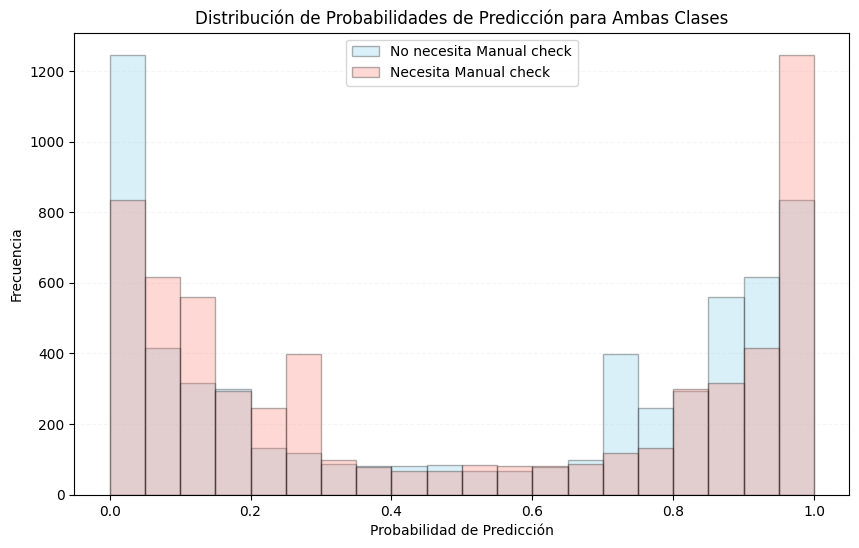

Accuracy: 0.9175106174452793
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.94      0.92      3124
           1       0.94      0.89      0.91      2998

    accuracy                           0.92      6122
   macro avg       0.92      0.92      0.92      6122
weighted avg       0.92      0.92      0.92      6122



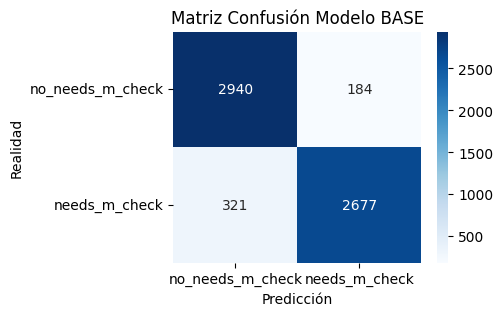

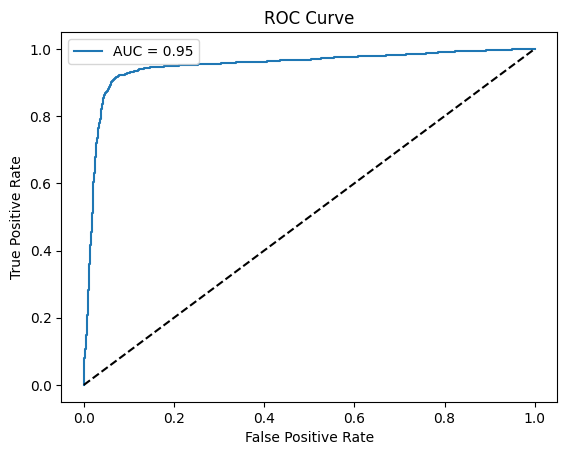

In [184]:
# Pasamos MODELO DE REGRESIÓN LOGISTICA BASE, con todas las caracteristicas para poder ver después la diferencia al aplicar Ridge y Lasso

# Obtener los nombres de las características
feature_names = X.columns

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)

# Crea el clasificador de regresión logística. El 'liblinear' usa metodo de optimización de minimos cuadrados generalizados (L2) y soporta la regularización L1 y L2
clf = LogisticRegression(solver="liblinear")

# Entrena el clasificador
clf.fit(X_train, y_train)

# Realiza predicciones sobre el conjunto de prueba
predicciones = clf.predict(X_test)

# Genera las probabilidades de predicción
predicciones_probabilidades = clf.predict_proba(X_test)

# Muestra las primeras 10 probabilidades de predicción
#predicciones_probabilidades[:10]

# Obtén los coeficientes y asigna los nombres de las características
coeficientes = clf.coef_[0]  # clf.coef_ es un array bidimensional, tomamos la primera fila
feature_coef = list(zip(feature_names, coeficientes))

# Ordena las características por el valor absoluto del coeficiente en orden descendente
feature_coef_sorted = sorted(feature_coef, key=lambda x: abs(x[1]), reverse=True)

# Imprime cada variable junto con su coeficiente ordenado
print("Coeficientes del modelo de regresión logística (ordenados por magnitud):")
for feature, coef in feature_coef_sorted:
    print(f"{feature}: {coef:.8f}")
    
# Convertir coeficientes a multiplicadores de odds
feature_odds = [(feature, np.exp(coef)) for feature, coef in feature_coef_sorted]

# Imprimir los resultados
print("\nOdds (elevando exp a los coeficientes):")
for feature, odds in feature_odds:
    print(f"{feature}: {odds:.8f}")
    
# Crea un histograma de las probabilidades de predicción para ambas clases
plt.figure(figsize=(10, 6)) 

# # Histograma para la clase negativa (no need manual check)
plt.hist(predicciones_probabilidades[:, 0], bins=20, color="skyblue", edgecolor="black", alpha=0.3, label="No necesita Manual check")
# Histograma para la clase positiva ( need manual check)
plt.hist(predicciones_probabilidades[:, 1], bins=20, color="salmon", edgecolor="black", alpha=0.3, label="Necesita Manual check")
# Título y etiquetas de los ejes
plt.title("Distribución de Probabilidades de Predicción para Ambas Clases")
plt.xlabel("Probabilidad de Predicción")
plt.ylabel("Frecuencia")
plt.legend(loc="upper center") 
# Muestra la leyenda en el gráfico
plt.grid(axis="y", linestyle="--", alpha=0.1)
plt.show()

# Evaluate model performance
print("Accuracy:", clf.score(X_test, y_test))  # Accuracy score
print("Classification Report:\n", classification_report(y_test, predicciones))  # Classification report

# Genera la matriz de confusión
matriz_confusion = confusion_matrix(y_test, predicciones)
columnas = ['no_needs_m_check', 'needs_m_check'] # 0 para No necesita manual check y 1 para Sí necesita manual check

# Visualiza la matriz de confusión utilizando un mapa de calor

plt.figure(figsize=(4, 3))
sns.heatmap(matriz_confusion, annot=True, fmt='d', cmap='Blues', xticklabels=columnas, yticklabels=columnas)
plt.title('Matriz Confusión Modelo BASE')
plt.xlabel("Predicción")
plt.ylabel("Realidad")
plt.show()

fpr, tpr, thresholds = roc_curve(y_test, predicciones_probabilidades[:, 1])
plt.plot(fpr, tpr, label=f"AUC = {auc(fpr, tpr):.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

Total de muestras: 500
500


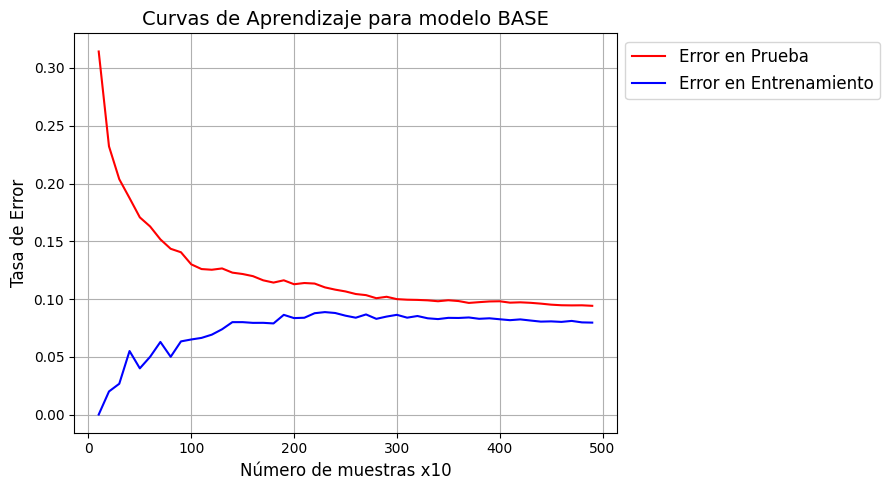

In [185]:
# Graficar curva de aprendizaje de nuestro MODELO BASE

np.random.seed(42)
# Parámetros
MAXN = 500 # len(X)  # Total de muestras disponibles
steps = 10  # Tamaño de incremento del conjunto de entrenamiento
iterations = 10  # Número de iteraciones para suavizar los resultados
print(f"Total de muestras: {MAXN}")

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2) #, random_state=42)
#display(X_test)
#display(y_test)

print(f"{(MAXN // steps) * steps + 0 }")

# Calcular el número de columnas
cols = list(range(steps, (MAXN // steps) * steps, steps))

# Inicializamos los DataFrames para almacenar los errores
test_errors = pd.DataFrame(np.zeros((iterations, len(cols))), columns=cols)
train_errors = pd.DataFrame(np.zeros((iterations, len(cols))), columns=cols)

# Generamos los errores promedios por iteración
for iteration in range(iterations):
    # Mezclamos los datos
    data = pd.concat([X, y], axis=1).sample(frac=1).reset_index(drop=True)
    X_shuffled = data[X.columns]
    y_shuffled = data[y.name]
    
    for N in range(steps, MAXN, steps):
        j = (N // steps) - 1  # Índice para almacenar resultados
        
        # Tomar un subconjunto de datos para entrenamiento
        X_subset = X_shuffled.iloc[:N, :]
        y_subset = y_shuffled.iloc[:N]
        
        # Crear y entrenar el modelo de regresión logística
        clf = LogisticRegression(solver="liblinear", max_iter=1000)
        clf.fit(X_subset, y_subset)
        
        # Evaluar el modelo en el conjunto de prueba y calcular la tasa de error.
        test_errors.iloc[iteration, j] = 1 - metrics.accuracy_score(clf.predict(X_test), y_test)
        # Evaluar el modelo en el conjunto de entrenamiento y calcular la tasa de error.
        train_errors.iloc[iteration, j] = 1 - metrics.accuracy_score(clf.predict(X_subset), y_subset)

# Promediar las tasas de error a lo largo de las iteraciones para obtener una curva de aprendizaje más estable.
mean_test_error = test_errors.mean(axis=0)
mean_train_error = train_errors.mean(axis=0)

# Graficar las curvas de aprendizaje: tasa de error en prueba y entrenamiento.
plt.figure(figsize=(9, 5))
plt.plot(mean_test_error, 'r', label='Error en Prueba') # Error en el conjunto de prueba.
plt.plot(mean_train_error, 'b', label='Error en Entrenamiento') # Error en el conjunto de entrenamiento.

# Configurar etiquetas, título y leyenda.
plt.xlabel('Número de muestras x10', fontsize=12)
plt.ylabel('Tasa de Error', fontsize=12)
plt.title('Curvas de Aprendizaje para modelo BASE', fontsize=14)
plt.legend(loc='upper left', fontsize=12, bbox_to_anchor=(1, 1))

# Mostrar la gráfica con las curvas de error.
plt.grid(True)
plt.tight_layout() # Ajustar la distribución para evitar que las etiquetas se corten.
plt.show()

In [186]:
# Probar modificando el umbral. Cambio a 0.4 (por ejemplo)
umbral = 0.4
predicciones_modificadas = (predicciones_probabilidades[:, 1] >= umbral).astype(int)

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.92      0.92      3124
           1       0.92      0.92      0.92      2998

    accuracy                           0.92      6122
   macro avg       0.92      0.92      0.92      6122
weighted avg       0.92      0.92      0.92      6122



Text(70.5815972222222, 0.5, 'Realidad')

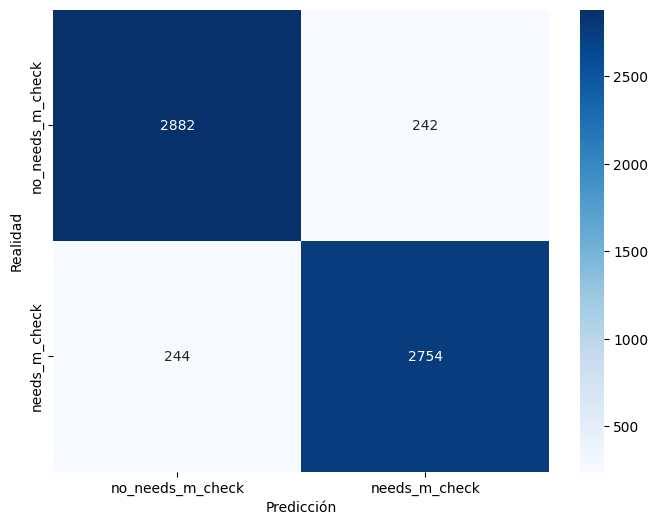

In [187]:
# Evaluate model performance con umbral modificado
#print("Accuracy:", clf.score(X_test, y_test))  # Accuracy score
print("Classification Report:\n", classification_report(y_test, predicciones_modificadas))  # Classification report

# Genera la matriz de confusión
matriz_confusion2 = confusion_matrix(y_test, predicciones_modificadas)
columnas = ['no_needs_m_check', 'needs_m_check'] # 0 para No necesita manual check y 1 para Sí necesita manual check

# Visualiza la matriz de confusión utilizando un mapa de calor
plt.figure(figsize=(8, 6))
sns.heatmap(matriz_confusion2, annot=True, fmt='d', cmap='Blues', xticklabels=columnas, yticklabels=columnas)
plt.xlabel("Predicción")
plt.ylabel("Realidad")

In [188]:
# Aplicar Penalizaciones Ridge y Lasso para Regresion Logistica al modelo base 

# Modelo con penalización L1 (similar a Lasso)
logreg_l1 = LogisticRegression(penalty='l1', solver='saga', C=1, random_state=42, max_iter=1000) #probar tb con solver='liblinear'
logreg_l1.fit(X_train, y_train)

# Modelo con penalización L2 (similar a Ridge)
logreg_l2 = LogisticRegression(penalty='l2', solver='lbfgs', C=1, random_state=42, max_iter=1000)
logreg_l2.fit(X_train, y_train)

# Predicciones
y_pred_l1 = logreg_l1.predict(X_test)
y_pred_l2 = logreg_l2.predict(X_test)

# Evaluación (por ejemplo, exactitud)
print("Accuracy L1 (LASSO):", accuracy_score(y_test, y_pred_l1))
print("Accuracy L2 (Ridge):", accuracy_score(y_test, y_pred_l2))


Accuracy L1 (LASSO): 0.9175106174452793
Accuracy L2 (Ridge): 0.9175106174452793


In [189]:
# Extraer los coeficientes para la L1
coefs = logreg_l1.coef_[0]  # Para regresión logística binaria, es un vector 1D

# Crear una lista con características y sus coeficientes
feature_coef_l1 = list(zip(feature_names, coefs))

# Ordenar las características por el valor absoluto del coeficiente en orden descendente
feature_coef_l1_sorted = sorted(feature_coef_l1, key=lambda x: abs(x[1]), reverse=True)

# Crear un DataFrame para visualizar los coeficientes junto con las características
importancia = pd.DataFrame({
    'Característica': feature_names,
    'Coeficiente': coefs
})

# Ordenar por la magnitud de los coeficientes
importancia = importancia.reindex(importancia['Coeficiente'].abs().sort_values(ascending=False).index)

# Mostrar las características con coeficientes no nulos (para Lasso)
importancia_no_nula = importancia[importancia['Coeficiente'] != 0]

print("\nCaracterísticas importantes para LASSO ordenadas por magnitud:")
print(importancia_no_nula)


Características importantes para LASSO ordenadas por magnitud:
           Característica  Coeficiente
6              n_recovery     3.027524
8              n_inc_fees     2.444062
5                 n_backs    -1.252410
4                  n_fees    -1.200544
9               n_cr_fe_w    -0.951585
7              n_inc_back     0.949757
15   charge_moment_before     0.395840
12                BTC_GBP    -0.348769
14  transfer_type_regular    -0.321776
3                  amount     0.268670
10              inflation    -0.244016
13          unemploy_rate     0.231352
0                 user_id     0.176909
2          created_at_dow    -0.015870
11                GBP_EUR    -0.004906
1         created_at_slot    -0.001650


In [190]:
# Extraer los coeficientes para la L2
coefs2 = logreg_l2.coef_[0]  # Para regresión logística binaria, es un vector 1D

# Crear una lista con características y sus coeficientes
feature_coef_l2 = list(zip(feature_names, coefs2))

# Ordenar las características por el valor absoluto del coeficiente en orden descendente
feature_coef_l2_sorted = sorted(feature_coef_l2, key=lambda x: abs(x[1]), reverse=True)

# Crear un DataFrame para visualizar los coeficientes junto con las características
importancia2 = pd.DataFrame({
    'Característica': feature_names,
    'Coeficiente': coefs2
})

# Ordenar por la magnitud de los coeficientes
importancia2 = importancia2.reindex(importancia2['Coeficiente'].abs().sort_values(ascending=False).index)

# Mostrar las características con coeficientes no nulos (para Lasso)
importancia_no_nula2 = importancia2[importancia2['Coeficiente'] != 0]

print("Características importantes para RIDGE:")
print(importancia_no_nula2)

Características importantes para RIDGE:
           Característica  Coeficiente
6              n_recovery     3.018767
8              n_inc_fees     2.442256
5                 n_backs    -1.251291
4                  n_fees    -1.198054
9               n_cr_fe_w    -0.951622
7              n_inc_back     0.949980
15   charge_moment_before     0.395609
12                BTC_GBP    -0.349154
14  transfer_type_regular    -0.323440
3                  amount     0.268433
10              inflation    -0.244531
13          unemploy_rate     0.229167
0                 user_id     0.177622
2          created_at_dow    -0.017500
11                GBP_EUR    -0.006682
1         created_at_slot    -0.002121


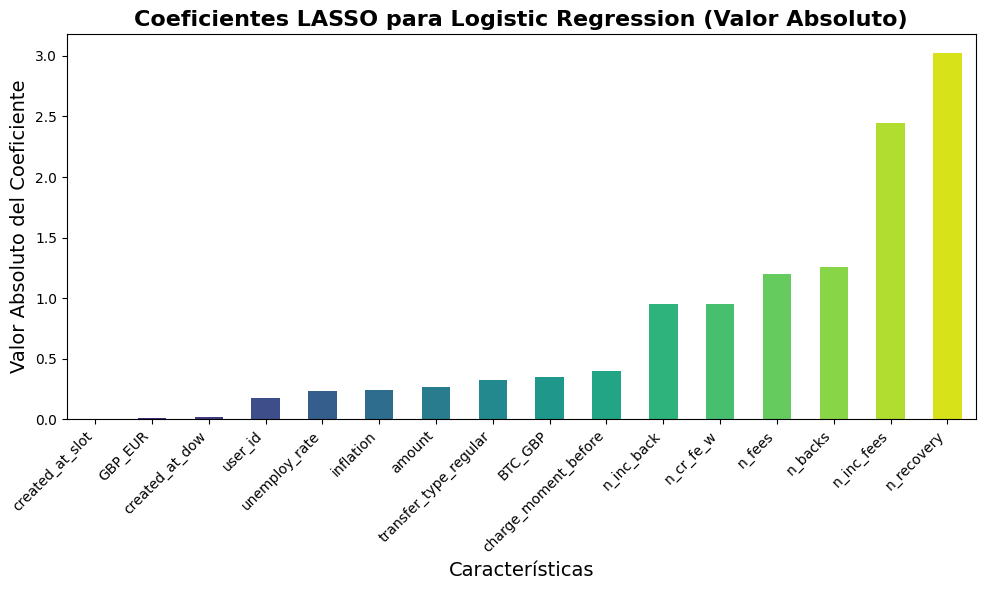

In [191]:
# Graficamos los coeficientes ordenados por valor absoluto LASSO
plt.figure(figsize=(10, 6))

# Convertir 'coefs' a un pandas.Series
coefs_series_l1 = pd.Series(coefs, index=X_train.columns)

# Ordenar los coeficientes de menor a mayor (en valor absoluto)
coefs_series_l1 = coefs_series_l1.abs().sort_values(ascending=True)

# graficar
coefs_series_l1.plot(kind='bar', color=sns.color_palette("viridis", n_colors=len(coefs_series_l1)))

# Añadimos el título y etiquetas a los ejes
plt.title('Coeficientes LASSO para Logistic Regression (Valor Absoluto)', fontsize=16, weight='bold')
plt.xlabel('Características', fontsize=14)
plt.ylabel('Valor Absoluto del Coeficiente', fontsize=14)
# Ajustamos las etiquetas del eje x para mejorar la legibilidad
plt.xticks(rotation=45, ha='right')
# Mostramos la gráfica con un diseño ajustado
plt.tight_layout() # Ajuste del espaciado para evitar solapamientos
plt.show()

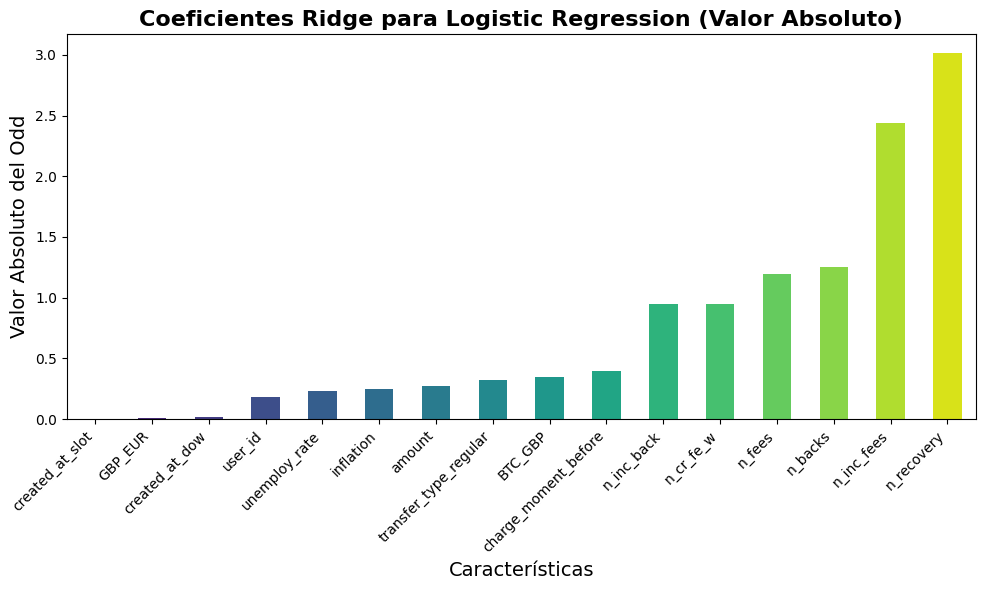

In [192]:
# Graficamos los coeficientes ordenados por valor absoluto RIDGE
plt.figure(figsize=(10, 6))

# Convertir 'coefs' a un pandas.Series
coefs_series_l2 = pd.Series(coefs2, index=X_train.columns)

# Ordenar los coeficientes de menor a mayor (en valor absoluto)
coefs_series_l2 = coefs_series_l2.abs().sort_values(ascending=True)

# Ordenar los coeficientes de menor a mayor (invirtiendo el orden)
coefs_series_l2.plot(kind='bar', color=sns.color_palette("viridis", n_colors=len(coefs_series_l2)))

# Añadimos el título y etiquetas a los ejes
plt.title('Coeficientes Ridge para Logistic Regression (Valor Absoluto)', fontsize=16, weight='bold')
plt.xlabel('Características', fontsize=14)
plt.ylabel('Valor Absoluto del Odd', fontsize=14)
# Ajustamos las etiquetas del eje x para mejorar la legibilidad
plt.xticks(rotation=45, ha='right')
# Mostramos la gráfica con un diseño ajustado
plt.tight_layout() # Ajuste del espaciado para evitar solapamientos
plt.show()

In [193]:
# Cálculo C optima de manera manual. LO DEJO COMENTADO PORQUE TARDA 11MINUTOS EN PROCESARSE

# # Definir valores de C para probar
# C_values = np.logspace(-4, 4, 10)
# scores_l1 = []
# scores_l2 = []

# # Iterar manualmente para penalización L1
# for C in C_values:
#     model_l1 = LogisticRegression(
#         C=C, penalty='l1', solver='saga', max_iter=1000, random_state=42
#     )
#     score = cross_val_score(model_l1, X_train, y_train, cv=5, scoring='accuracy').mean()
#     scores_l1.append(score)

# # Iterar manualmente para penalización L2
# for C in C_values:
#     model_l2 = LogisticRegression(
#         C=C, penalty='l2', solver='saga', max_iter=1000, random_state=42
#     )
#     score = cross_val_score(model_l2, X_train, y_train, cv=5, scoring='accuracy').mean()
#     scores_l2.append(score)

# # Encontrar el mejor C
# optimal_C_l1 = C_values[np.argmax(scores_l1)]
# optimal_C_l2 = C_values[np.argmax(scores_l2)]

# print(f"Mejor valor de C para penalización L1: {optimal_C_l1}")
# print(f"Mejor valor de C para penalización L2: {optimal_C_l2}")


In [194]:
# Buscamos el C optimo (el alpha optimo) para estas penalizaciones. Ahora con el LogisticRegressionCV que tiene Validación Cruzada incorporada.

# Definir valores de C para probar
C_values = np.logspace(-4, 4, 10)

# Modelo con penalización L1
logreg_l1 = LogisticRegressionCV(
    Cs=C_values,  # Valores de C a probar
    cv=5,         # Número de folds para validación cruzada
    penalty='l1',
    solver='saga', # Solver compatible con L1
    max_iter=1000,
    random_state=42
)
logreg_l1.fit(X_train, y_train)

# Modelo con penalización L2
logreg_l2 = LogisticRegressionCV(
    Cs=C_values,  # Valores de C a probar
    cv=5,         # Número de folds para validación cruzada
    penalty='l2',
    solver='saga', # Solver compatible con L2
    max_iter=1000,
    random_state=42
)
logreg_l2.fit(X_train, y_train)

# Encontrar los valores óptimos de C
optimal_C_l1 = logreg_l1.C_[0]
optimal_C_l2 = logreg_l2.C_[0]

print(f"Mejor valor de C para penalización L1: {optimal_C_l1}")
print(f"Mejor valor de C para penalización L2: {optimal_C_l2}")


Mejor valor de C para penalización L1: 2.782559402207126
Mejor valor de C para penalización L2: 166.81005372000558


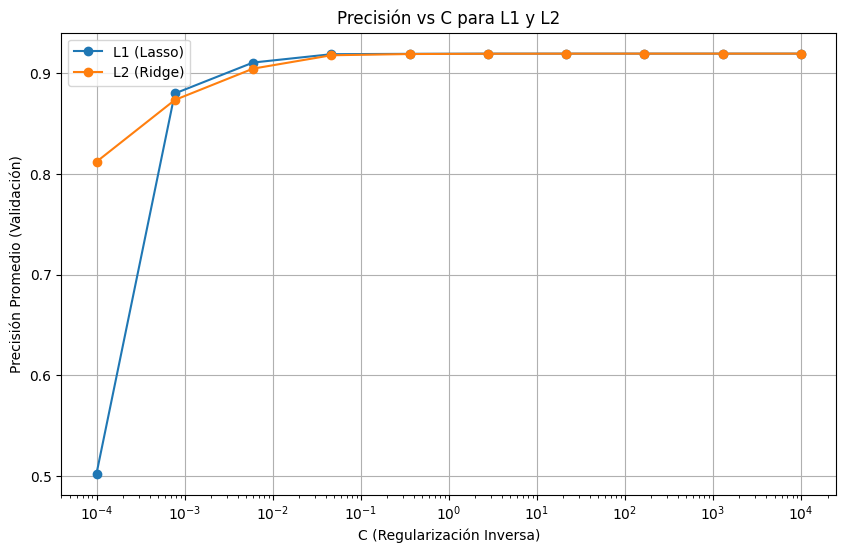

In [195]:
# Graficar precisión promedio para cada C
plt.figure(figsize=(10, 6))
plt.plot(C_values, logreg_l1.scores_[1].mean(axis=0), label='L1 (Lasso)', marker='o')
plt.plot(C_values, logreg_l2.scores_[1].mean(axis=0), label='L2 (Ridge)', marker='o')

plt.xscale('log')  # Escala logarítmica para C
plt.xlabel('C (Regularización Inversa)')
plt.ylabel('Precisión Promedio (Validación)')
plt.title('Precisión vs C para L1 y L2')
plt.legend()
plt.grid(True)
plt.show()

Podemos ver la que L2 tiene una curva más estable para C pequeñas. Así que L2 es robusta frente a los cambios de C (de la regularización) 

In [196]:
# Ver los puntajes promedio por validación cruzada para cada C
scores_l1 = logreg_l1.scores_[1].mean(axis=0)  # Precisión promedio para cada valor de C
scores_l2 = logreg_l2.scores_[1].mean(axis=0)

# Mostrar C óptimos
print("Puntajes promedio para L1:", scores_l1)
print("Puntajes promedio para L2:", scores_l2)

# Comprobar el índice del mejor puntaje (C óptimo)
optimal_index_l1 = scores_l1.argmax()
optimal_index_l2 = scores_l2.argmax()

print(f"\nÍndice óptimo para L1: {optimal_index_l1} \nMejor C: {logreg_l1.Cs_[optimal_index_l1]}")
print(f"\nÍndice óptimo para L2: {optimal_index_l2} \nMejor C: {logreg_l2.Cs_[optimal_index_l2]}")

Puntajes promedio para L1: [0.5025729  0.87997213 0.91068368 0.9189739  0.91934144 0.91954564
 0.91954564 0.91954564 0.91954564 0.91954564]
Puntajes promedio para L2: [0.8121783  0.87351936 0.90463916 0.91791206 0.91913724 0.91942311
 0.9195048  0.91954564 0.91954564 0.91954564]

Índice óptimo para L1: 5 
Mejor C: 2.782559402207126

Índice óptimo para L2: 7 
Mejor C: 166.81005372000558


In [197]:
# Probamos MODELO REGRESION LOGISTICA con este analisis 

# Entrenar el modelo final con el valor óptimo de C
logreg_l1_optimal = LogisticRegression(penalty='l1', solver='saga', C=optimal_C_l1, random_state=42, max_iter=1000)
logreg_l2_optimal = LogisticRegression(penalty='l2', solver='saga', C=optimal_C_l2, random_state=42, max_iter=1000)

# Entrenar los modelos con el valor de C óptimo
logreg_l1_optimal.fit(X_train, y_train)
logreg_l2_optimal.fit(X_train, y_train)

LogisticRegression(C=np.float64(166.81005372000558), max_iter=1000,
                   random_state=42, solver='saga')

In [198]:
# Realizar predicciones en el conjunto de prueba
y_pred_l1 = logreg_l1_optimal.predict(X_test)
y_pred_l2 = logreg_l2_optimal.predict(X_test)

# Evaluar el desempeño del modelo L1
print("Evaluación del modelo Lasso (L1):")
print("Precisión:", accuracy_score(y_test, y_pred_l1))
print("Reporte de clasificación L1:\n", classification_report(y_test, y_pred_l1))

# Evaluar el desempeño del modelo L2
print("Evaluación del modelo Ridge (L2):")
print("Precisión:", accuracy_score(y_test, y_pred_l2))
print("Reporte de clasificación L2:\n", classification_report(y_test, y_pred_l2))

Evaluación del modelo Lasso (L1):
Precisión: 0.9175106174452793
Reporte de clasificación L1:
               precision    recall  f1-score   support

           0       0.90      0.94      0.92      3124
           1       0.94      0.89      0.91      2998

    accuracy                           0.92      6122
   macro avg       0.92      0.92      0.92      6122
weighted avg       0.92      0.92      0.92      6122

Evaluación del modelo Ridge (L2):
Precisión: 0.9175106174452793
Reporte de clasificación L2:
               precision    recall  f1-score   support

           0       0.90      0.94      0.92      3124
           1       0.94      0.89      0.91      2998

    accuracy                           0.92      6122
   macro avg       0.92      0.92      0.92      6122
weighted avg       0.92      0.92      0.92      6122



Coeficientes del modelo Ridge (L2) (ordenados por magnitud):
n_recovery: 3.03589469
n_inc_fees: 2.44784692
n_backs: -1.25385744
n_fees: -1.20567127
n_cr_fe_w: -0.95306652
n_inc_back: 0.95115608
charge_moment_before: 0.39775562
BTC_GBP: -0.35045694
transfer_type_regular: -0.32406203
amount: 0.26972015
inflation: -0.24453948
unemploy_rate: 0.23286001
user_id: 0.17730872
created_at_dow: -0.01732537
GBP_EUR: -0.00639747
created_at_slot: -0.00201564

Coeficientes del modelo Lasso (L1) (ordenados por magnitud):
n_recovery: 3.03295337
n_inc_fees: 2.44651048
n_backs: -1.25334753
n_fees: -1.20385676
n_cr_fe_w: -0.95254237
n_inc_back: 0.95065833
charge_moment_before: 0.39707562
BTC_GBP: -0.34985274
transfer_type_regular: -0.32324987
amount: 0.26934663
inflation: -0.24435199
unemploy_rate: 0.23232208
user_id: 0.17716467
created_at_dow: -0.01680163
GBP_EUR: -0.00586103
created_at_slot: -0.00188395


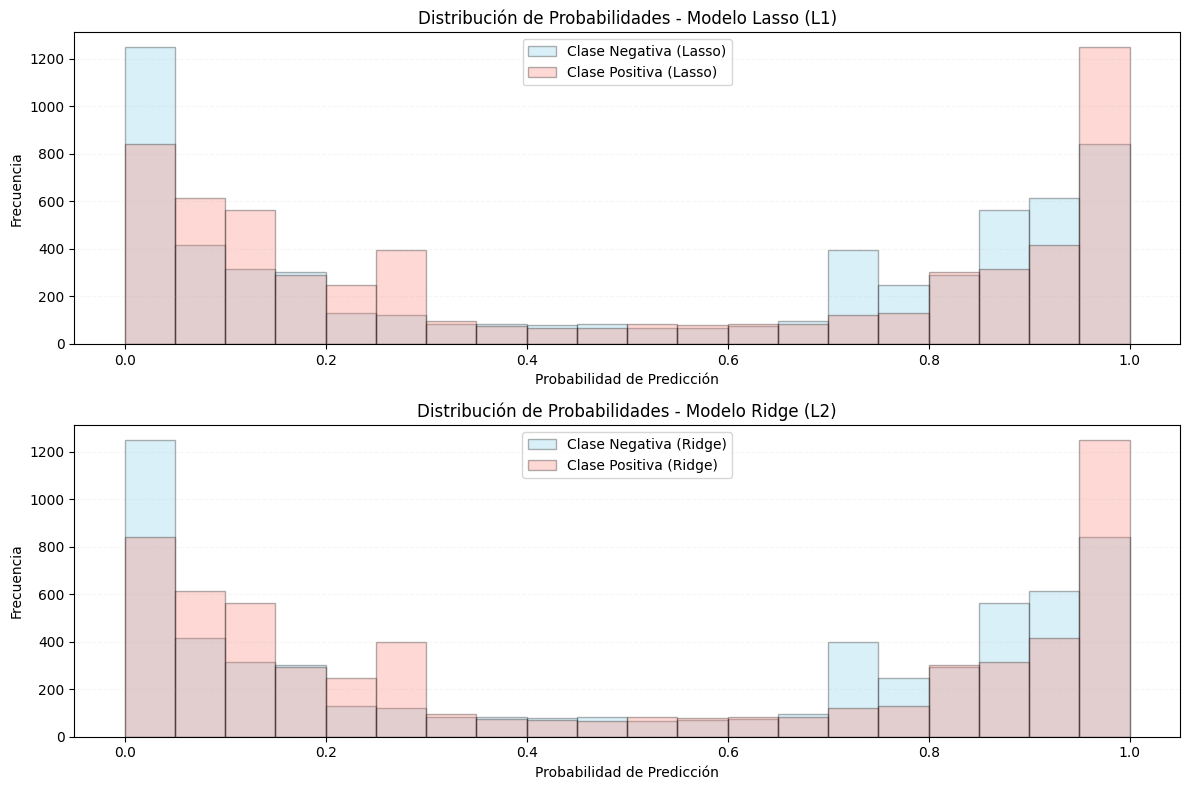

Desempeño del Modelo Lasso (L1):
Accuracy: 0.9175106174452793
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.94      0.92      3124
           1       0.94      0.89      0.91      2998

    accuracy                           0.92      6122
   macro avg       0.92      0.92      0.92      6122
weighted avg       0.92      0.92      0.92      6122


Desempeño del Modelo Ridge (L2):
Accuracy: 0.9175106174452793
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.94      0.92      3124
           1       0.94      0.89      0.91      2998

    accuracy                           0.92      6122
   macro avg       0.92      0.92      0.92      6122
weighted avg       0.92      0.92      0.92      6122



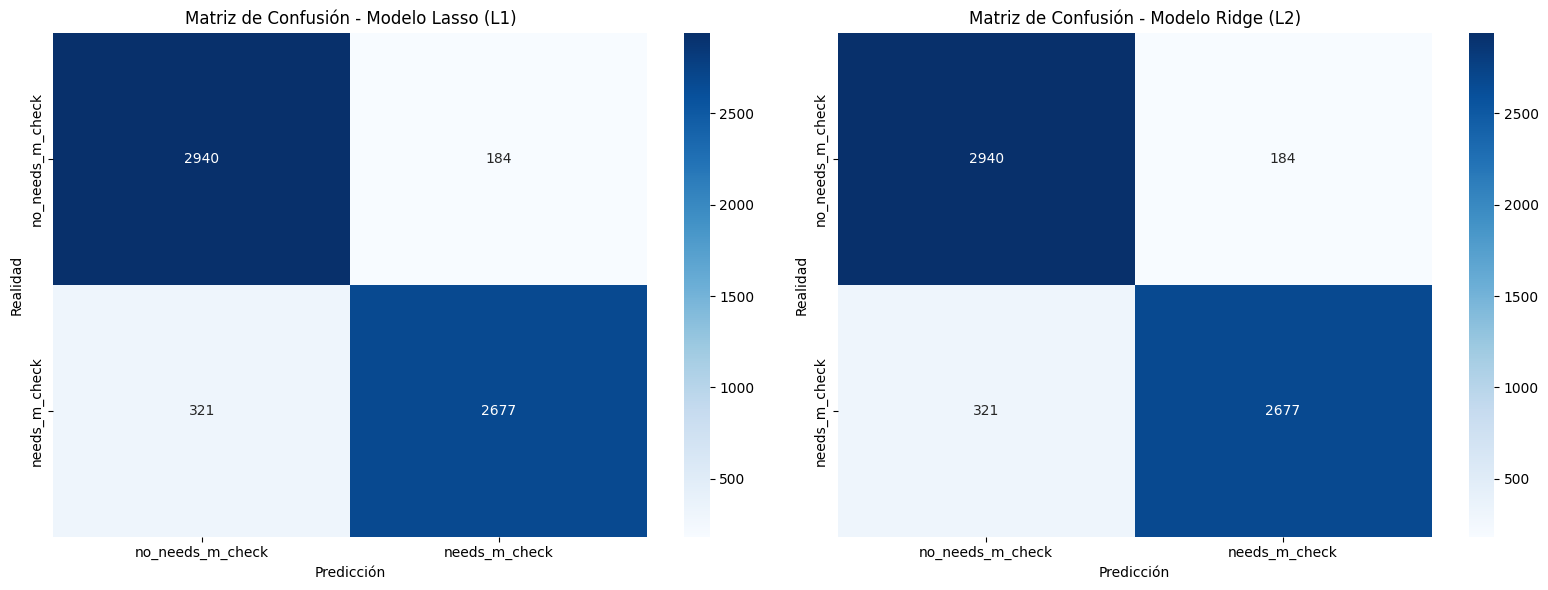

In [199]:
# Genera las probabilidades de predicción para ambos modelos
predicciones_prob_l1 = logreg_l1_optimal.predict_proba(X_test)
predicciones_prob_l2 = logreg_l2_optimal.predict_proba(X_test)

# Obtén los coeficientes de ambos modelos
coef_l1 = logreg_l1_optimal.coef_[0]  # Array unidimensional
coef_l2 = logreg_l2_optimal.coef_[0]

# Asocia los coeficientes con los nombres de las características
feature_coef_l1 = list(zip(feature_names, coef_l1))
feature_coef_l2 = list(zip(feature_names, coef_l2))

# Ordena las características por valor absoluto del coeficiente
feature_coef_l1_sorted = sorted(feature_coef_l1, key=lambda x: abs(x[1]), reverse=True)
feature_coef_l2_sorted = sorted(feature_coef_l2, key=lambda x: abs(x[1]), reverse=True)

# Imprime las características ordenadas por magnitud del coeficiente
print("Coeficientes del modelo Ridge (L2) (ordenados por magnitud):")
for feature, coef in feature_coef_l2_sorted:
    print(f"{feature}: {coef:.8f}")

print("\nCoeficientes del modelo Lasso (L1) (ordenados por magnitud):")
for feature, coef in feature_coef_l1_sorted:
    print(f"{feature}: {coef:.8f}")

# Crea histogramas para ambas clases y modelos
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.hist(predicciones_prob_l1[:, 0], bins=20, color="skyblue", edgecolor="black", alpha=0.3, label="Clase Negativa (Lasso)")
plt.hist(predicciones_prob_l1[:, 1], bins=20, color="salmon", edgecolor="black", alpha=0.3, label="Clase Positiva (Lasso)")
plt.title("Distribución de Probabilidades - Modelo Lasso (L1)")
plt.xlabel("Probabilidad de Predicción")
plt.ylabel("Frecuencia")
plt.legend(loc="upper center")
plt.grid(axis="y", linestyle="--", alpha=0.1)

plt.subplot(2, 1, 2)
plt.hist(predicciones_prob_l2[:, 0], bins=20, color="skyblue", edgecolor="black", alpha=0.3, label="Clase Negativa (Ridge)")
plt.hist(predicciones_prob_l2[:, 1], bins=20, color="salmon", edgecolor="black", alpha=0.3, label="Clase Positiva (Ridge)")
plt.title("Distribución de Probabilidades - Modelo Ridge (L2)")
plt.xlabel("Probabilidad de Predicción")
plt.ylabel("Frecuencia")
plt.legend(loc="upper center")
plt.grid(axis="y", linestyle="--", alpha=0.1)
plt.tight_layout()
plt.show()

# Evaluación de desempeño para ambos modelos

print("Desempeño del Modelo Lasso (L1):")
print("Accuracy:", logreg_l1_optimal.score(X_test, y_test))
print("Classification Report:\n", classification_report(y_test, y_pred_l1))

print("\nDesempeño del Modelo Ridge (L2):")
print("Accuracy:", logreg_l2_optimal.score(X_test, y_test))
print("Classification Report:\n", classification_report(y_test, y_pred_l2))

# Generar matrices de confusión para ambos modelos
matriz_confusion_l1 = confusion_matrix(y_test, y_pred_l1)
matriz_confusion_l2 = confusion_matrix(y_test, y_pred_l2)

# Visualizar matrices de confusión usando mapas de calor
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
sns.heatmap(matriz_confusion_l1, annot=True, fmt='d', cmap='Blues', xticklabels=columnas, yticklabels=columnas)
plt.title("Matriz de Confusión - Modelo Lasso (L1)")
plt.xlabel("Predicción")
plt.ylabel("Realidad")

plt.subplot(1, 2, 2)
sns.heatmap(matriz_confusion_l2, annot=True, fmt='d', cmap='Blues', xticklabels=columnas, yticklabels=columnas)
plt.title("Matriz de Confusión - Modelo Ridge (L2)")
plt.xlabel("Predicción")
plt.ylabel("Realidad")

plt.tight_layout()
plt.show()


In [200]:
# Comparación resultados entre MODELO BASE y el modelo entrenado según LASSO y RIDGE

# ROC-AUC para cada modelo
roc_auc_base = roc_auc_score(y_test, predicciones)
roc_auc_umbral = roc_auc_score(y_test, predicciones_modificadas)
roc_auc_ridge = roc_auc_score(y_test, y_pred_l2)
roc_auc_lasso = roc_auc_score(y_test, y_pred_l1)

# Base model
accuracy_base = accuracy_score(y_test, predicciones)
precision_base = precision_score(y_test, predicciones)
recall_base = recall_score(y_test, predicciones)
f1_base = f1_score(y_test, predicciones)
roc_auc_base = roc_auc_score(y_test, predicciones)

# Base model con umbral modificado
accuracy_umbral = accuracy_score(y_test, predicciones_modificadas)
precision_umbral = precision_score(y_test, predicciones_modificadas)
recall_umbral = recall_score(y_test, predicciones_modificadas)
f1_umbral = f1_score(y_test, predicciones_modificadas)
roc_auc_umbral = roc_auc_score(y_test, predicciones_modificadas)

# Ridge model
accuracy_ridge = accuracy_score(y_test, y_pred_l2)
precision_ridge = precision_score(y_test, y_pred_l2)
recall_ridge = recall_score(y_test, y_pred_l2)
f1_ridge = f1_score(y_test, y_pred_l2)
roc_auc_ridge = roc_auc_score(y_test, y_pred_l2)

# Lasso model
accuracy_lasso = accuracy_score(y_test, y_pred_l1)
precision_lasso = precision_score(y_test, y_pred_l1)
recall_lasso = recall_score(y_test, y_pred_l1)
f1_lasso = f1_score(y_test, y_pred_l1)
roc_auc_lasso = roc_auc_score(y_test, y_pred_l1)

# Comparar métricas clave en una tabla

metricas = {
    "R_LOG StandardScaler": ["Base", "Umbral 0.4","Ridge", "Lasso"],
    "Accuracy": [accuracy_base, accuracy_umbral ,accuracy_ridge, accuracy_lasso],
    "Precision": [precision_base, precision_umbral,precision_ridge, precision_lasso],
    "Recall": [recall_base, recall_umbral, recall_ridge, recall_lasso],
    "F1-Score": [f1_base, f1_umbral, f1_ridge, f1_lasso],
    "ROC-AUC": [roc_auc_base, roc_auc_umbral, roc_auc_ridge, roc_auc_lasso],
}

df_metricas = pd.DataFrame(metricas)
print(df_metricas)


  R_LOG StandardScaler  Accuracy  Precision    Recall  F1-Score   ROC-AUC
0                 Base  0.917511   0.935687  0.892929  0.913808  0.917015
1           Umbral 0.4  0.920614   0.919226  0.918612  0.918919  0.920574
2                Ridge  0.917511   0.935687  0.892929  0.913808  0.917015
3                Lasso  0.917511   0.935687  0.892929  0.913808  0.917015


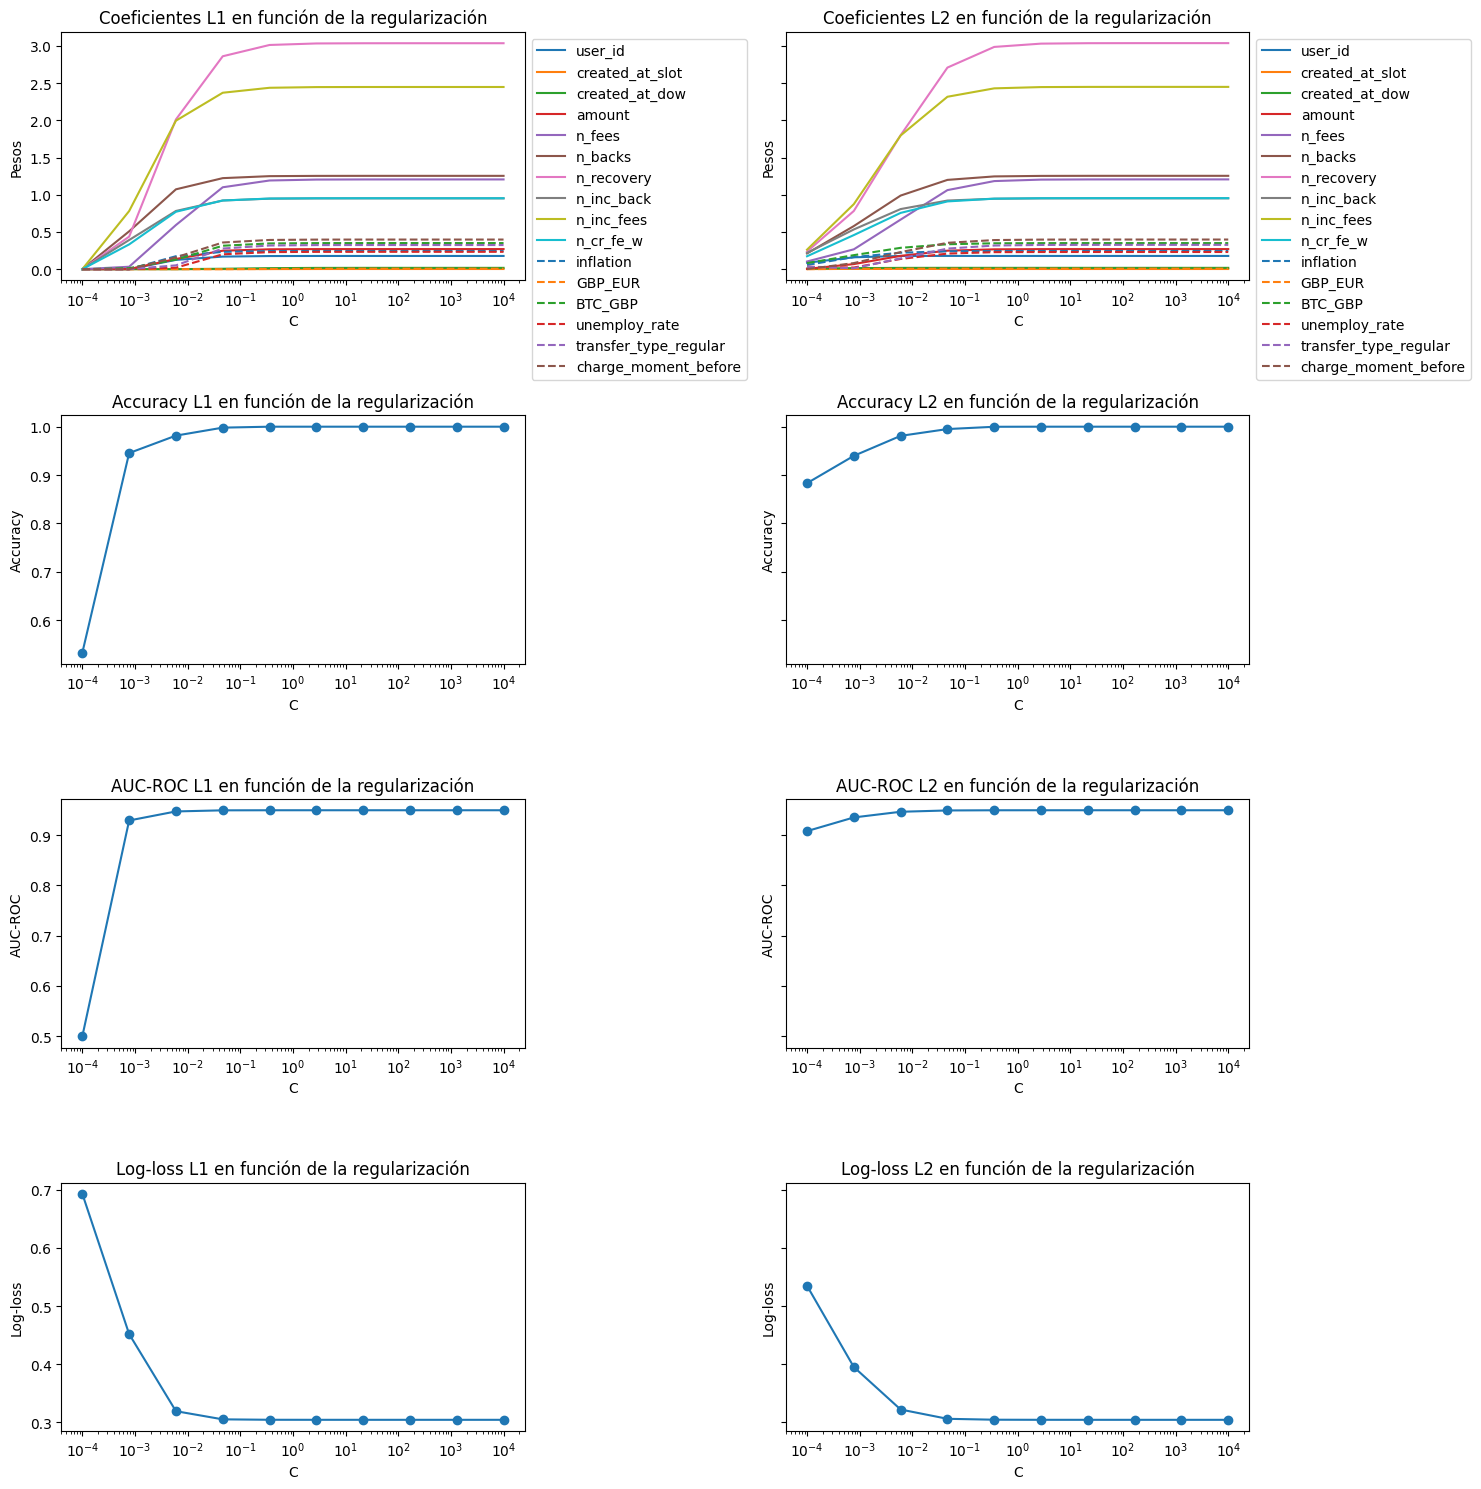

In [201]:
# Graficar el C (que es 1/alpha)

# Valores de C para probar (equivalente a 1/alpha en regresión logística)
C_values = np.logspace(-4, 4, 10)

# Inicialización de listas para almacenar resultados
coefs_logreg_l1 = []
coefs_logreg_l2 = []
accuracy_l1 = []
accuracy_l2 = []
auc_l1 = []
auc_l2 = []
logloss_l1 = []
logloss_l2 = []

# Modelos y evaluación
for C in C_values:
    # Penalización L1
    logreg_l1 = LogisticRegression(penalty='l1', C=C, solver='saga', max_iter=1000, random_state=42)
    logreg_l1.fit(X_train, y_train)
    coefs_logreg_l1.append(logreg_l1.coef_[0])  # Guardar coeficientes
    y_pred_prob_l1 = logreg_l1.predict_proba(X_test)[:, 1]  # Probabilidades para ROC y log-loss
    accuracy_l1.append(logreg_l1.score(X_test, y_pred_l1))
    auc_l1.append(roc_auc_score(y_test, y_pred_prob_l1))  # AUC-ROC
    logloss_l1.append(log_loss(y_test, y_pred_prob_l1))  # Log-loss

    # Penalización L2
    logreg_l2 = LogisticRegression(penalty='l2', C=C, solver='lbfgs', max_iter=1000, random_state=42)
    logreg_l2.fit(X_train, y_train)
    coefs_logreg_l2.append(logreg_l2.coef_[0])  # Guardar coeficientes
    y_pred_prob_l2 = logreg_l2.predict_proba(X_test)[:, 1]
    accuracy_l2.append(logreg_l2.score(X_test, y_pred_l2))
    auc_l2.append(roc_auc_score(y_test, y_pred_prob_l2))  # AUC-ROC
    logloss_l2.append(log_loss(y_test, y_pred_prob_l2))  # Log-loss


# Configuración del gráfico
fig, axs = plt.subplots(4, 2, figsize=(15, 15), sharey='row')

# Definir los colores y estilos de línea
colors = plt.cm.tab10.colors  # Paleta de colores
line_styles = ['-', '--', '-.', ':']  # Diferentes tipos de línea

# Coeficientes L1
for i, coef in enumerate(np.abs(coefs_logreg_l1).T):
    # El color se toma de la paleta y el estilo de línea se alterna según el índice
    color = colors[i % 10]  # Asignar uno de los primeros 10 colores
    line_style = line_styles[i // 10 % len(line_styles)]  # Alternar entre los diferentes tipos de línea cada 10
    axs[0, 0].plot(C_values, coef, label=feature_names[i], color=color, linestyle=line_style)

axs[0, 0].set_xscale('log')
axs[0, 0].set_title('Coeficientes L1 en función de la regularización')
axs[0, 0].set_xlabel('C')
axs[0, 0].set_ylabel('Pesos')
axs[0, 0].legend(feature_names)

# Coloca la leyenda fuera del gráfico
axs[0,0].legend(feature_names, loc='upper left', bbox_to_anchor=(1, 1))

# Coeficientes L2
for i, coef in enumerate(np.abs(coefs_logreg_l2).T):
    # El color se toma de la paleta y el estilo de línea se alterna según el índice
    color = colors[i % 10]  # Asignar uno de los primeros 10 colores
    line_style = line_styles[i // 10 % len(line_styles)]  # Alternar entre los diferentes tipos de línea cada 10
    axs[0, 1].plot(C_values, coef, label=feature_names[i], color=color, linestyle=line_style)

axs[0, 1].set_xscale('log')
axs[0, 1].set_title('Coeficientes L2 en función de la regularización')
axs[0, 1].set_xlabel('C')
axs[0, 1].set_ylabel('Pesos')
axs[0, 1].legend(feature_names)

# Coloca la leyenda fuera del gráfico
axs[0,1].legend(feature_names, loc='upper left', bbox_to_anchor=(1, 1))

#Graficar Accuracy para ver como varia un función de las C
# Accuracy L1
axs[1, 0].plot(C_values, accuracy_l1, marker='o')
axs[1, 0].set_xscale('log')
axs[1, 0].set_title('Accuracy L1 en función de la regularización')
axs[1, 0].set_xlabel('C')
axs[1, 0].set_ylabel('Accuracy')

# Accuracy L2
axs[1, 1].plot(C_values, accuracy_l2, marker='o')
axs[1, 1].set_xscale('log')
axs[1, 1].set_title('Accuracy L2 en función de la regularización')
axs[1, 1].set_xlabel('C')
axs[1, 1].set_ylabel('Accuracy')

#Graficar AUC-ROC para ver como cambia rendimiento del modelo en términos de discriminación entre las clases postiva y negativa
# AUC-ROC L1
axs[2, 0].plot(C_values, auc_l1, marker='o')
axs[2, 0].set_xscale('log')
axs[2, 0].set_title('AUC-ROC L1 en función de la regularización')
axs[2, 0].set_xlabel('C')
axs[2, 0].set_ylabel('AUC-ROC')

# AUC-ROC L2
axs[2, 1].plot(C_values, auc_l2, marker='o')
axs[2, 1].set_xscale('log')
axs[2, 1].set_title('AUC-ROC L2 en función de la regularización')
axs[2, 1].set_xlabel('C')
axs[2, 1].set_ylabel('AUC-ROC')

# Graficar Log-loss para ver como cambia la calidad de las predicciones (mide la perdida del modelo,los errores q hace)
# Log-loss L1
axs[3, 0].plot(C_values, logloss_l1, marker='o')
axs[3, 0].set_xscale('log')
axs[3, 0].set_title('Log-loss L1 en función de la regularización')
axs[3, 0].set_xlabel('C')
axs[3, 0].set_ylabel('Log-loss')

# Log-loss L2
axs[3, 1].plot(C_values, logloss_l2, marker='o')
axs[3, 1].set_xscale('log')
axs[3, 1].set_title('Log-loss L2 en función de la regularización')
axs[3, 1].set_xlabel('C')
axs[3, 1].set_ylabel('Log-loss')

plt.tight_layout()
plt.show()


In [210]:
X

,n_inc_fees,n_recovery,n_fees,n_backs,n_cr_fe_w,BTC_GBP
1,-0.492353,-0.409684,-0.877507,-0.343263,-0.023796,-2.651036
7,-0.492353,-0.409684,-0.877507,-0.343263,-0.023796,-2.733861
9,-0.492353,-0.409684,-0.877507,-0.343263,-0.023796,-2.733861
10,-0.492353,-0.409684,-0.877507,-0.343263,-0.023796,-2.733861
13,-0.492353,-0.409684,-0.877507,-0.343263,-0.023796,-2.733861
...,...,...,...,...,...,...
13553,-0.492353,-0.409684,-0.877507,-1.060095,-1.176266,0.464133
14996,0.436399,0.780088,0.007022,1.807231,-1.176266,0.564722
29830,-0.027977,-0.409684,0.007022,-0.343263,-0.023796,1.581788
31153,-0.492353,-0.409684,-0.877507,-1.060095,-1.176266,1.913273


Total de muestras: 1500
1500


/home/albagd/ProyectoPastaLoca2/myenv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/albagd/ProyectoPastaLoca2/myenv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/albagd/ProyectoPastaLoca2/myenv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/albagd/ProyectoPastaLoca2/myenv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/albagd/ProyectoPastaLoca2/myenv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warni

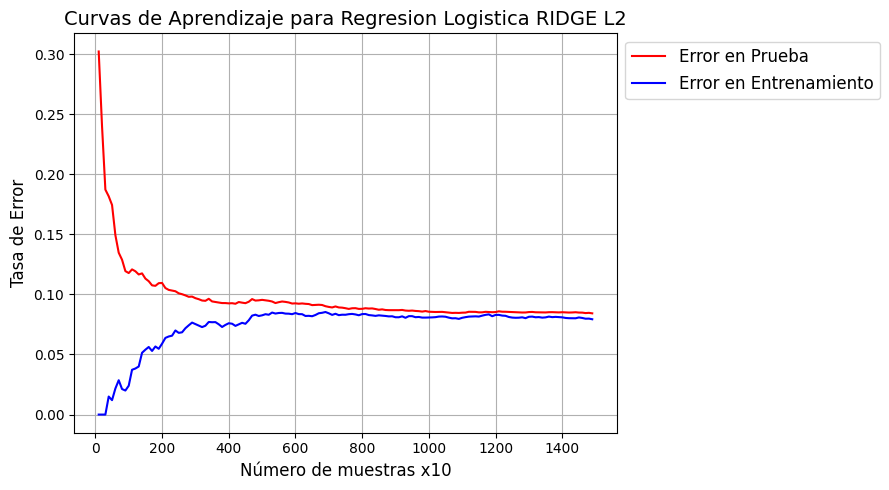

In [202]:
# Graficar curvas de error. Ahora para el MODELO con Regularización RIDGE (L2)

np.random.seed(42)
# Parámetros
MAXN = 1500 # len(X)  # Total de muestras disponibles
steps = 10  # Tamaño de incremento del conjunto de entrenamiento
iterations = 10  # Número de iteraciones para suavizar los resultados
print(f"Total de muestras: {MAXN}")

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2) #, random_state=42)
#display(X_test)
#display(y_test)

print(f"{(MAXN // steps) * steps + 0 }")

# Calcular el número de columnas
cols = list(range(steps, (MAXN // steps) * steps, steps))

# Inicializamos los DataFrames para almacenar los errores
test_errors = pd.DataFrame(np.zeros((iterations, len(cols))), columns=cols)
train_errors = pd.DataFrame(np.zeros((iterations, len(cols))), columns=cols)

# Generamos los errores promedios por iteración
for iteration in range(iterations):
    # Mezclamos los datos
    data = pd.concat([X, y], axis=1).sample(frac=1).reset_index(drop=True)
    X_shuffled = data[X.columns]
    y_shuffled = data[y.name]
    
    for N in range(steps, MAXN, steps):
        j = (N // steps) - 1  # Índice para almacenar resultados
        
        # Tomar un subconjunto de datos para entrenamiento
        X_subset = X_shuffled.iloc[:N, :]
        y_subset = y_shuffled.iloc[:N]
        
        # Crear y entrenar el modelo de regresión logística
        logreg_l2_optimal = LogisticRegression(penalty='l2', solver='saga', C=optimal_C_l2, random_state=42, max_iter=1000)
        #clf = LogisticRegression(solver="liblinear", max_iter=1000)
        logreg_l2_optimal.fit(X_subset, y_subset)
        
        # Evaluar el modelo en el conjunto de prueba y calcular la tasa de error.
        test_errors.iloc[iteration, j] = 1 - metrics.accuracy_score(logreg_l2_optimal.predict(X_test), y_test)
        # Evaluar el modelo en el conjunto de entrenamiento y calcular la tasa de error.
        train_errors.iloc[iteration, j] = 1 - metrics.accuracy_score(logreg_l2_optimal.predict(X_subset), y_subset)

# Promediar las tasas de error a lo largo de las iteraciones para obtener una curva de aprendizaje más estable.
mean_test_error = test_errors.mean(axis=0)
mean_train_error = train_errors.mean(axis=0)

# Graficar las curvas de aprendizaje: tasa de error en prueba y entrenamiento.
plt.figure(figsize=(9, 5))
plt.plot(mean_test_error, 'r', label='Error en Prueba') # Error en el conjunto de prueba.
plt.plot(mean_train_error, 'b', label='Error en Entrenamiento') # Error en el conjunto de entrenamiento.

# Configurar etiquetas, título y leyenda.
plt.xlabel('Número de muestras x10', fontsize=12)
plt.ylabel('Tasa de Error', fontsize=12)
plt.title('Curvas de Aprendizaje para Regresion Logistica RIDGE L2', fontsize=14)
plt.legend(loc='upper left', fontsize=12, bbox_to_anchor=(1, 1))

# Mostrar la gráfica con las curvas de error.
plt.grid(True)
plt.tight_layout() # Ajustar la distribución para evitar que las etiquetas se corten.
plt.show()

In [203]:
# Convertir de nuevo a DataFrame, preservando nombres de columnas e índices
X_final = pd.DataFrame(normalizado, columns=X_log_L.columns, index=df_balanced.index)

In [204]:
df_final=X_final[['n_inc_fees','n_recovery','n_fees','n_backs','n_cr_fe_w','BTC_GBP']]

In [205]:
df_final

,n_inc_fees,n_recovery,n_fees,n_backs,n_cr_fe_w,BTC_GBP
1,-0.492353,-0.409684,-0.877507,-0.343263,-0.023796,-2.651036
7,-0.492353,-0.409684,-0.877507,-0.343263,-0.023796,-2.733861
9,-0.492353,-0.409684,-0.877507,-0.343263,-0.023796,-2.733861
10,-0.492353,-0.409684,-0.877507,-0.343263,-0.023796,-2.733861
13,-0.492353,-0.409684,-0.877507,-0.343263,-0.023796,-2.733861
...,...,...,...,...,...,...
13553,-0.492353,-0.409684,-0.877507,-1.060095,-1.176266,0.464133
14996,0.436399,0.780088,0.007022,1.807231,-1.176266,0.564722
29830,-0.027977,-0.409684,0.007022,-0.343263,-0.023796,1.581788
31153,-0.492353,-0.409684,-0.877507,-1.060095,-1.176266,1.913273


Coeficientes del modelo de regresión logística (ordenados por magnitud):
n_recovery: 2.74681192
n_inc_fees: 2.65582376
n_backs: -1.36121189
n_cr_fe_w: -1.07176228
n_fees: -0.68551643
BTC_GBP: -0.14422383

Odds (elevando exp a los coeficientes):
n_recovery: 15.59284130
n_inc_fees: 14.23670886
n_backs: 0.25634992
n_cr_fe_w: 0.34240457
n_fees: 0.50382997
BTC_GBP: 0.86569396


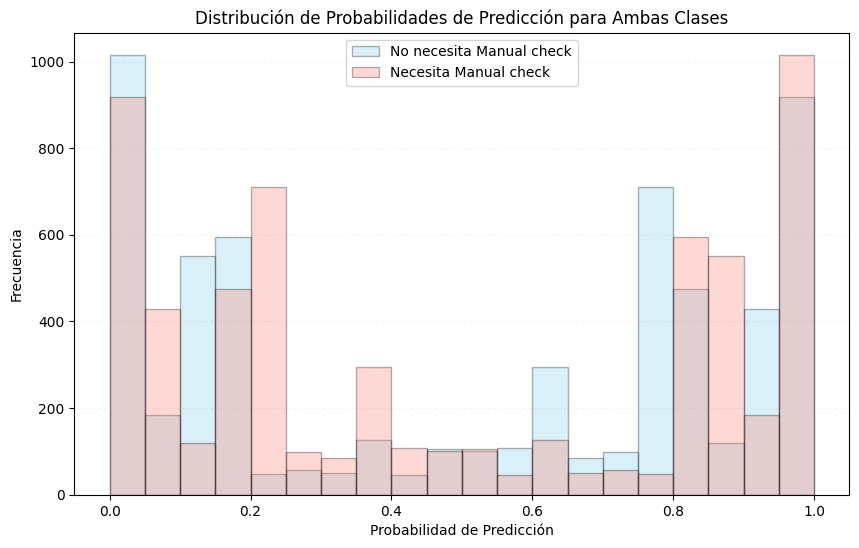

Accuracy: 0.919797451813133
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.96      0.92      3124
           1       0.95      0.88      0.92      2998

    accuracy                           0.92      6122
   macro avg       0.92      0.92      0.92      6122
weighted avg       0.92      0.92      0.92      6122



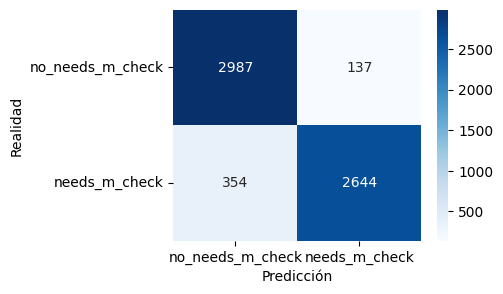

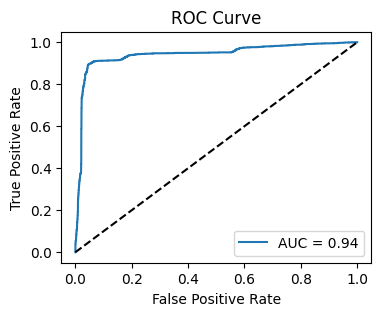

In [212]:
# Modelo Regresión Logística aplicando características seleccionadas manualmente.

# Obtener los nombres de las características
feature_names = df_final.columns

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(df_final,y,test_size=0.2, random_state=42)

# Crea el clasificador de regresión logística. El 'liblinear' usa metodo de optimización de minimos cuadrados generalizados (L2) y soporta la regularización L1 y L2
clf = LogisticRegression(solver="liblinear")

# Entrena el clasificador
clf.fit(X_train, y_train)

# Realiza predicciones sobre el conjunto de prueba
predicciones = clf.predict(X_test)

# Genera las probabilidades de predicción
predicciones_probabilidades = clf.predict_proba(X_test)

# Muestra las primeras 10 probabilidades de predicción
#predicciones_probabilidades[:10]

# Obtén los coeficientes y asigna los nombres de las características
coeficientes = clf.coef_[0]  # clf.coef_ es un array bidimensional, tomamos la primera fila
feature_coef = list(zip(feature_names, coeficientes))

# Ordena las características por el valor absoluto del coeficiente en orden descendente
feature_coef_sorted = sorted(feature_coef, key=lambda x: abs(x[1]), reverse=True)

# Imprime cada variable junto con su coeficiente ordenado
print("Coeficientes del modelo de regresión logística (ordenados por magnitud):")
for feature, coef in feature_coef_sorted:
    print(f"{feature}: {coef:.8f}")
    
# Convertir coeficientes a multiplicadores de odds
feature_odds = [(feature, np.exp(coef)) for feature, coef in feature_coef_sorted]

# Imprimir los resultados
print("\nOdds (elevando exp a los coeficientes):")
for feature, odds in feature_odds:
    print(f"{feature}: {odds:.8f}")
    
# Crea un histograma de las probabilidades de predicción para ambas clases
plt.figure(figsize=(10, 6)) 

# # Histograma para la clase negativa (no need manual check)
plt.hist(predicciones_probabilidades[:, 0], bins=20, color="skyblue", edgecolor="black", alpha=0.3, label="No necesita Manual check")
# Histograma para la clase positiva ( need manual check)
plt.hist(predicciones_probabilidades[:, 1], bins=20, color="salmon", edgecolor="black", alpha=0.3, label="Necesita Manual check")
# Título y etiquetas de los ejes
plt.title("Distribución de Probabilidades de Predicción para Ambas Clases")
plt.xlabel("Probabilidad de Predicción")
plt.ylabel("Frecuencia")
plt.legend(loc="upper center") 
# Muestra la leyenda en el gráfico
plt.grid(axis="y", linestyle="--", alpha=0.1)
plt.show()

# Evaluate model performance
print("Accuracy:", clf.score(X_test, y_test))  # Accuracy score
print("Classification Report:\n", classification_report(y_test, predicciones))  # Classification report

# Genera la matriz de confusión
matriz_confusion = confusion_matrix(y_test, predicciones)
columnas = ['no_needs_m_check', 'needs_m_check'] # 0 para No necesita manual check y 1 para Sí necesita manual check

# Visualiza la matriz de confusión utilizando un mapa de calor

plt.figure(figsize=(4, 3))
sns.heatmap(matriz_confusion, annot=True, fmt='d', cmap='Blues', xticklabels=columnas, yticklabels=columnas)
plt.xlabel("Predicción")
plt.ylabel("Realidad")
plt.show()

plt.figure(figsize=(4, 3))
fpr, tpr, thresholds = roc_curve(y_test, predicciones_probabilidades[:, 1])
plt.plot(fpr, tpr, label=f"AUC = {auc(fpr, tpr):.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


In [207]:
# Cálculo porcentaje de Falsos Negativos y de Falsos Positivos

# Extraer los valores de la matriz de confusión
TN, FP, FN, TP = matriz_confusion.ravel()

# Calcular el porcentaje de Falsos Negativos
porcentaje_FN = (FN / (FN + TP)) * 100

# Calcular el porcentaje de Falsos Positivos
porcentaje_FP = (FP / (FP + TN)) * 100

# Imprimir los resultados
print(f"Porcentaje de Falsos Negativos: {porcentaje_FN:.2f}%")
print(f"Porcentaje de Falsos Positivos: {porcentaje_FP:.2f}%")


Porcentaje de Falsos Negativos: 11.81%
Porcentaje de Falsos Positivos: 4.39%


Total de muestras: 500
500


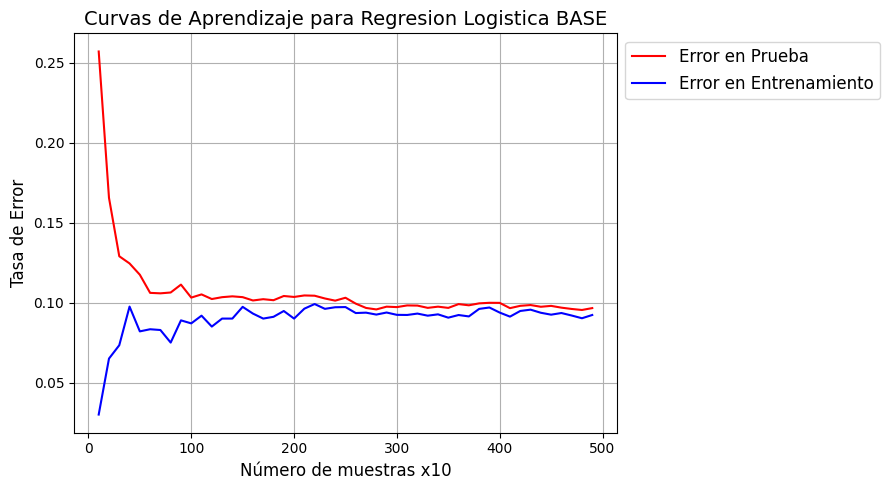

In [208]:
# Graficar curvas de error. 
X=df_final
np.random.seed(42)
# Parámetros
MAXN = 500 # len(X)  # Total de muestras disponibles
steps = 10  # Tamaño de incremento del conjunto de entrenamiento
iterations = 10  # Número de iteraciones para suavizar los resultados
print(f"Total de muestras: {MAXN}")

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2) #, random_state=42)
#display(X_test)
#display(y_test)

print(f"{(MAXN // steps) * steps + 0 }")

# Calcular el número de columnas
cols = list(range(steps, (MAXN // steps) * steps, steps))

# Inicializamos los DataFrames para almacenar los errores
test_errors = pd.DataFrame(np.zeros((iterations, len(cols))), columns=cols)
train_errors = pd.DataFrame(np.zeros((iterations, len(cols))), columns=cols)

# Generamos los errores promedios por iteración
for iteration in range(iterations):
    # Mezclamos los datos
    data = pd.concat([X, y], axis=1).sample(frac=1).reset_index(drop=True)
    X_shuffled = data[X.columns]
    y_shuffled = data[y.name]
    
    for N in range(steps, MAXN, steps):
        j = (N // steps) - 1  # Índice para almacenar resultados
        
        # Tomar un subconjunto de datos para entrenamiento
        X_subset = X_shuffled.iloc[:N, :]
        y_subset = y_shuffled.iloc[:N]
        
        # Crear y entrenar el modelo de regresión logística
        clf = LogisticRegression(solver="liblinear", max_iter=1000)
        clf.fit(X_subset, y_subset)
        
        # Evaluar el modelo en el conjunto de prueba y calcular la tasa de error.
        test_errors.iloc[iteration, j] = 1 - metrics.accuracy_score(clf.predict(X_test), y_test)
        # Evaluar el modelo en el conjunto de entrenamiento y calcular la tasa de error.
        train_errors.iloc[iteration, j] = 1 - metrics.accuracy_score(clf.predict(X_subset), y_subset)

# Promediar las tasas de error a lo largo de las iteraciones para obtener una curva de aprendizaje más estable.
mean_test_error = test_errors.mean(axis=0)
mean_train_error = train_errors.mean(axis=0)

# Graficar las curvas de aprendizaje: tasa de error en prueba y entrenamiento.
plt.figure(figsize=(9, 5))
plt.plot(mean_test_error, 'r', label='Error en Prueba') # Error en el conjunto de prueba.
plt.plot(mean_train_error, 'b', label='Error en Entrenamiento') # Error en el conjunto de entrenamiento.

# Configurar etiquetas, título y leyenda.
plt.xlabel('Número de muestras x10', fontsize=12)
plt.ylabel('Tasa de Error', fontsize=12)
plt.title('Curvas de Aprendizaje para Regresion Logistica BASE', fontsize=14)
plt.legend(loc='upper left', fontsize=12, bbox_to_anchor=(1, 1))

# Mostrar la gráfica con las curvas de error.
plt.grid(True)
plt.tight_layout() # Ajustar la distribución para evitar que las etiquetas se corten.
plt.show()

In [209]:
# Aplicamos K-Fold validation al modelo con selección manual de características

# Define el modelo de regresión logística
log_reg = LogisticRegression(max_iter=1000, solver='liblinear')  # Ajusta el solver según tu modelo

# Configura el K-Fold Cross-Validation
kfold = KFold(n_splits=10, shuffle=True, random_state=42)  # Ajusta n_splits según tu preferencia

# Define las métricas a evaluar
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score),
    'roc_auc': 'roc_auc'  # Usa la métrica predefinida en lugar de make_scorer
}

# Ejecuta la validación cruzada
cv_results = cross_validate(log_reg, X, y, cv=kfold, scoring=scoring, return_train_score=True)

# Muestra los resultados
print("Resultados de Validación Cruzada (Promedios):")
print(f"Precisión: {cv_results['test_accuracy'].mean():.4f}")
print(f"Precision: {cv_results['test_precision'].mean():.4f}")
print(f"Recall: {cv_results['test_recall'].mean():.4f}")
print(f"F1-Score: {cv_results['test_f1'].mean():.4f}")
print(f"ROC-AUC: {cv_results['test_roc_auc'].mean():.4f}")

# Si deseas detalles para cada fold:
print("\nResultados por Fold:")
for metric in scoring.keys():
    print(f"{metric.capitalize()} por Fold: {cv_results[f'test_{metric}']}")


Resultados de Validación Cruzada (Promedios):
Precisión: 0.9174
Precision: 0.9482
Recall: 0.8830
F1-Score: 0.9144
ROC-AUC: 0.9379

Resultados por Fold:
Accuracy por Fold: [0.91800065 0.92355439 0.91963411 0.91734727 0.91048677 0.9163672
 0.91506044 0.92061418 0.91993464 0.9127451 ]
Precision por Fold: [0.95293266 0.9487909  0.95416667 0.94275618 0.93642018 0.94507042
 0.94729445 0.95680346 0.94939271 0.94827586]
Recall por Fold: [0.87616511 0.89171123 0.88416988 0.88579017 0.88158751 0.88289474
 0.87932159 0.87896825 0.89220038 0.87747288]
F1 por Fold: [0.91293791 0.91936595 0.91783567 0.91338583 0.90817694 0.91292517
 0.9120433  0.91623578 0.91990847 0.91150149]
Roc_auc por Fold: [0.94074973 0.94296975 0.93718033 0.93807428 0.93307193 0.93580467
 0.9374445  0.93830164 0.94096334 0.93401861]
